# MPPI Simulation - Cartpole
© 2023 Tomohiro Sasaki, All Rights Reserved.

In [1]:
using Plots; gr()
using LinearAlgebra
using Revise
using CDDP

using DifferentialEquations
using DataInterpolations
using BenchmarkTools
using Printf

using Random

In [2]:
tf = 10. # final time
tN = 500 # number of time steps
dt = tf/tN # time step
hN = 100; # horizon length

In [4]:
includet("../src/models/cartpole.jl")
model = CartPole()

# initial state
# x_init = model.x_init
x_init = [0, pi/6, 0, 0]

# final state
# x_final = model.x_final
x_final = [0, pi, 0, 0]

# model dimensions
nx, nu = model.dims.nx, model.dims.nu
;

In [5]:
X0, U0 = initialize_trajectory(model, tf, tN, x_init, model.f!);

In [7]:
function stage_cost(
    x::Vector{Float64},
    x_ref::Vector{Float64},
)
    # NOTE: Define only for state stege cost
    
    # Q = 1.0e-2*Diagonal(ones(size(x,1)))
    # Q = zeros(4,4)
    # R = 1.0e-1*Diagonal(ones(u_dim))
    # return  0.5 * transpose(x - x_ref) * Q * (x - x_ref) 

    return x[1]^2 + 50 * (1 + cos(x[2]))^2 + 1/2 * x[3]^2 +  1/2 * x[4]^2
end

function terminal_cost(
    x::Vector{Float64},
    x_ref::Vector{Float64},
)
    
    # Qf = 1.0e+2*Diagonal(ones(size(x,1)))
    # Qf = 1.0e+0*Diagonal([1; 1; 1; 1])
    Qf = zeros(4,4)
    
    return 0.5 * transpose(x - x_ref) * Qf * (x - x_ref)
end
;

In [13]:
X_ref = x_final .* ones(nx, hN+1) # discretized reference trajectory
problem = MPPIProblemCPU(
    model,
    tf=dt*hN,
    tN=hN,
    dt=dt,
    dims=model.dims,
    cost_funcs=MPPICostFunction(ell=stage_cost, phi=terminal_cost),
    dyn_funcs=MPPIDynamicsFunction(f=model.f, f! =model.f!),
    x_init=x_init,
    x_final=x_final,
    X_ref=X_ref,
);

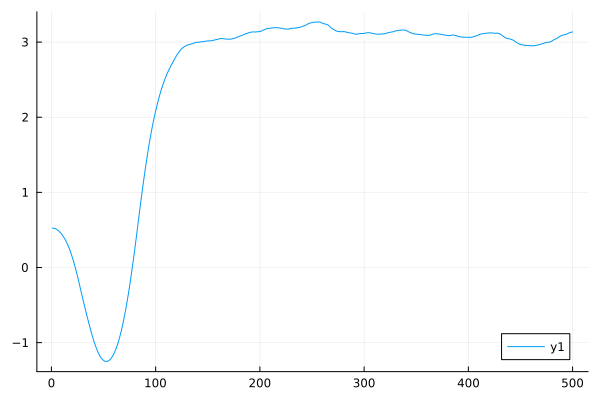

In [34]:
U = nothing
K = 10
λ = 50.
μ = 0.0
Σ = 1e-1
u = [0.0]

X_sol = zeros(nx, tN)
U_sol = zeros(nu, tN)
dist = Normal(0, 1e-0)
δU = rand(dist, nu, hN, K, tN)
X_sol[:,1] = x_init
params_arr = model.params.arr
dyn_funcs = problem.dyn_funcs

# MPPI simulations
for j in 1:tN-1
    δu = δU[:,:,:,j]    
    problem.x_init = X_sol[:, j]
    u_out, U = solve_mppi(problem, U=U, K=K, λ=λ, μ=μ, Σ=Σ, verbose=false, δu=δu)
    # u_out, U = solve_mppi_old(problem, U=U, K=K, λ=λ, μ=μ, Σ=Σ, verbose=false, δu=δu)

    p = ODEParameter(params=params_arr, U_ref=u_out)
    X_sol[:, j+1] = X_sol[:, j] + rk4_step(dyn_funcs.f, X_sol[:, j], p, 0.0, dt) * dt
    U_sol[:, j] = u_out
end
plot(X_sol[2,:])

In [49]:
# U = nothing
# K = 1000
# λ = 100.
# μ = 0.0
# Σ = 1e-0
# u = [0.0]
# X, U = @time simulate_mppi(problem, U=U, K=K, λ=λ, μ=μ, Σ=Σ, verbose=false, δU=δU)

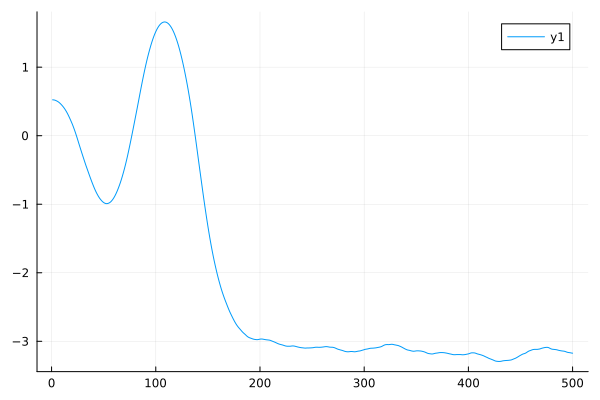

In [32]:
plot(X_sol[2,:])